In [1]:
import pandas as pd 
import numpy as np 
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
import plotly.express as px
# from wordcloud import WordCloud, STOPWORDS 
# from wordcloud import STOPWORDS
# from collections import Counter 
# from textblob import TextBlob
# stopwords = set(STOPWORDS) 
import pickle
# import pyLDAvis.sklearn
from nltk.probability import FreqDist
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
# from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import *
from tensorflow.keras.preprocessing.text import one_hot
#Deep learning libraries
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import tqdm
from nltk.tokenize import word_tokenize
from tensorflow.keras import regularizers, initializers, optimizers, callbacks

from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
stop=set(stopwords.words('english'))

In [3]:
final=pd.read_csv('final.csv')

In [4]:
entire =final.copy()


In [5]:
wordnet = WordNetLemmatizer()
#regex = re.compile('[%s]' % re.escape(string.punctuation))

In [6]:
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stop]
    text=[wordnet.lemmatize(w) for w in text]
    
    text = " ".join(text)
    return text

In [7]:
entire['Text']=entire['Text'].map(lambda x: cleantext(x))

In [12]:
y=entire['Label']

In [13]:
entire2=entire.copy()

In [14]:
# entire2.drop('Label',axis=1,inplace=True)


### ALTERNATE TEXT PROCESSING

In [15]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100   
GLOVE_DIR = "glove.6B.100d.txt"

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(entire2['Text'])
    
print("Tokeniser created - Saving Tokeniser")
    
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
print("Tokeniser saved")

Tokeniser created - Saving Tokeniser
Tokeniser saved


In [17]:
def basic_text_cleaning(line_from_column):
    # This function takes in a string, not a list or an array for the arg line_from_column
    
    tokenized_doc = word_tokenize(line_from_column)
    
    new_review = []
    for token in tokenized_doc:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)
    
    new_term_vector = []
    for word in new_review:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
    
    final_doc = []
    for word in new_term_vector:
        final_doc.append(wordnet.lemmatize(word))
    
    return ' '.join(final_doc)

In [18]:
def get_dummies(df, col_target):
    df_y = pd.get_dummies(df[col_target])
    df_new = df.join(df_y)
    df_new = df_new.drop(col_target,axis=1)
    return df_new

In [19]:
def prep_features(df, labels, text):
    y = df[labels].values
    comments_train = df[text]
    comments_train = list(comments_train)
    
    return comments_train, y

In [20]:
def prepare_training_test_data(texts,tokenizer,y):
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Vocabulary size:', len(word_index))
    
    print("Padding sequences")
    
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', data.shape)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = y[indices]
    
    num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
    x_train = data[: -num_validation_samples]
    y_train = labels[: -num_validation_samples]
    x_val = data[-num_validation_samples: ]
    y_val = labels[-num_validation_samples: ]
    
    print('Number of entries in each category:')
    print('training: ', y_train.sum(axis=0))
    print('validation: ', y_val.sum(axis=0))
    
    print('Tokenized sentences: \n', data[0])
    print('One hot label: \n', labels[0])
    
    return x_train, y_train, x_val, y_val

In [21]:
df_labels =  pd.get_dummies(entire2["Label"])
df_labels = df_labels.reset_index()
df_labels = df_labels.drop("index",axis=1)
df_labels.head()

,0,1
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0


In [23]:
entire3= get_dummies(df=entire2, col_target="Label")
entire3.head()

,Text,0,1
0,coronavirus india amid covid 19 worry governme...,1,0
1,claim stated india top business conglomerate t...,0,1
2,facebook post shared hundred time claim u pres...,0,1
3,29 new covid 19 case reported china delivery m...,1,0
4,uk hospital covid 19 death toll rise 761 12 86...,1,0


In [27]:
x_train, y_train = prep_features(df=entire3, labels=[0,1], text="Text")
print(x_train[0])
print(y_train[0])


coronavirus india amid covid 19 worry government diy step homemade mask ndtvnewsbeeps pic twitter com xzrqsixftx
[1 0]


In [28]:
# corpus=list(entire2['Text'])
# y=entire2['Label']

In [26]:
y

0        0
1        1
2        1
3        0
4        0
        ..
25824    0
25825    1
25826    0
25827    0
25828    0
Name: Label, Length: 25829, dtype: int64

In [29]:
x_train,y_train,x_test,y_test = prepare_training_test_data(texts=x_train,tokenizer=tokenizer,y=y_train)

Vocabulary size: 30739
Padding sequences
Shape of data tensor: (25829, 200)
Number of entries in each category:
training:  [11426  9238]
validation:  [2793 2372]
Tokenized sentences: 
 [ 171  976  239  383  296  441 3751 3674 1410 2149 1047 3371  244 1184
  296 1853  402    1    2  239 1341   91  957 1471 1011 1517   72 1341
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    

In [30]:
# y_train=tf.one_hot(y_train,depth2)
# y_test=tf.one_hot(y_train,depth2)

In [31]:
embeddings_index = {}
word_index = tokenizer.word_index
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [32]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [33]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [34]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 100)          3074000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [38]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [39]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32,callbacks=callbacks_list, validation_data=(x_test, y_test),verbose=1)

Training progress:
Epoch 1/20
645/646 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8820
Epoch 1: val_accuracy improved from -inf to 0.86989, saving model to weights.best.hdf5
646/646 [==============================] - 42s 64ms/step - loss: 0.2786 - accuracy: 0.8821 - val_loss: 0.3085 - val_accuracy: 0.8699
Epoch 2/20
646/646 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9010
Epoch 2: val_accuracy improved from 0.86989 to 0.87086, saving model to weights.best.hdf5
646/646 [==============================] - 42s 65ms/step - loss: 0.2422 - accuracy: 0.9010 - val_loss: 0.3122 - val_accuracy: 0.8709
Epoch 3/20
645/646 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9133
Epoch 3: val_accuracy did not improve from 0.87086
646/646 [==============================] - 44s 68ms/step - loss: 0.2118 - accuracy: 0.9133 - val_loss: 0.3221 - val_accuracy: 0.8699
Epoch 4/20
646/646 [==============================] - ETA: 0s - lo

In [40]:
model.save("LSTM_model_1.h5")

In [41]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
import matplotlib.pyplot as plt

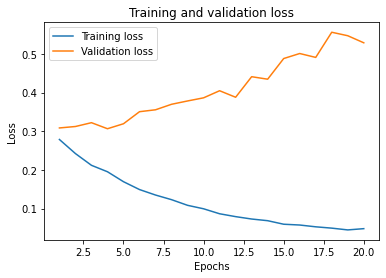

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [45]:
def predict(model,i):
    clean_text =[]
    
    i = cleantext(i)
    clean_text.append(i)
    sequences = tokenizer.texts_to_sequences(clean_text)
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    pred = model.predict(data)
    return pred

In [50]:
y_test_pred=model.predict(x_test).argmax(axis=-1)

162/162 [==============================] - 6s 37ms/step


In [57]:
y_test_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [85]:
len(y_test_pred)

5165

In [55]:
y_test

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [84]:
len(y_test)

5165

In [91]:
y_test_new=[]

In [92]:
for i in range(0,len(y_test)):
    if y_test[i][0]==1:
        y_test_new.append(0)
    else:
        y_test_new.append(1)

In [94]:
len(y_test_new)

5165

In [95]:
y_test_new=np.array(y_test_new)

In [96]:
len(y_test_new)

5165

In [76]:
test='WHO claims Cancer cures covid'

In [77]:
y_pred= predict(model=model,i=test).argmax(axis=-1)

1/1 [==============================] - 0s 35ms/step


In [78]:
y_pred

array([1], dtype=int64)

In [97]:
np.save('X_train_deep2.npy',x_train)
np.save('X_test_deep2.npy',x_test)
np.save('y_train_deep2.npy',y_train)
np.save('y_test_deep2.npy',y_test)
np.save('y_test_deep2_new.npy',y_test_new)
np.save('y_pred_deep2.npy',y_test_pred)


In [98]:
#Confusion matrix
cm = metrics.confusion_matrix(y_test_new, y_test_pred)

Confusion matrix for LSTM model on test data 


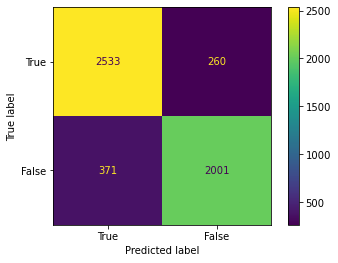

In [101]:
LSTM_report=metrics.classification_report(y_test_pred,y_test_new,output_dict=True)
LSTM_report=pd.DataFrame(LSTM_report).transpose()
LSTM_report.to_csv('LSTM_report.csv',index=False)



disp=metrics.ConfusionMatrixDisplay(cm,display_labels=["True","False"])
print("Confusion matrix for LSTM model on test data ")
disp.plot()
plt.show()

Confusion matrix for LSTM model on test data 


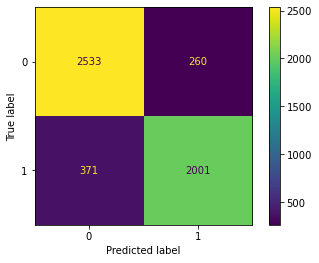

In [102]:
disp=metrics.ConfusionMatrixDisplay(cm)
print("Confusion matrix for LSTM model on test data ")
disp.plot()
plt.show()

In [100]:
LSTM_report

,precision,recall,f1-score,support
0,0.906910,0.872245,0.889240,2904.000000
1,0.843592,0.885007,0.863803,2261.000000
accuracy,0.877832,0.877832,0.877832,0.877832
macro avg,0.875251,0.878626,0.876522,5165.000000
weighted avg,0.879192,0.877832,0.878105,5165.000000


In [126]:
text_pred1=(model1.predict(embedded_text) > 0.5).astype("int32")

1/1 [==============================] - 0s 96ms/step


In [127]:
text_pred1

array([[1]])

In [123]:
entire.iloc[1]['Text']

'claim stated india top business conglomerate tata group chairman ratan tata said time think profits think survival'